In [5]:
# Cell 1 - imports & settings
import os, sys, math, warnings, datetime
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from reportlab.platypus import Image as RLImage, Paragraph, Spacer


import xgboost as xgb
import shap
import joblib
import plotly.graph_objects as go

# Optional libs
try:
    import umap
    UMAP_AVAILABLE = True
except Exception:
    UMAP_AVAILABLE = False

try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except Exception:
    HDBSCAN_AVAILABLE = False

try:
    from reportlab.lib.pagesizes import A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
    from reportlab.lib.styles import getSampleStyleSheet
    REPORTLAB_AVAILABLE = True
except Exception:
    REPORTLAB_AVAILABLE = False

# Plot show config
plt.rcParams.update({'figure.figsize': (8,4)})
print("UMAP:", UMAP_AVAILABLE, "HDBSCAN:", HDBSCAN_AVAILABLE, "REPORTLAB:", REPORTLAB_AVAILABLE)


UMAP: False HDBSCAN: False REPORTLAB: True


In [6]:
# Cell 2 - load dataset (adjust path if needed)
DATA_PATH = "f5_15 to 21.csv"   # change if needed
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found in working directory {os.getcwd()}")

df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
# show sample
display(df.head(2))


Loaded shape: (122841, 106)


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,27,1987-06-24,169,67,Argentina,FC Barcelona,...,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,29,1985-02-05,185,80,Portugal,Real Madrid,...,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3


In [7]:
# Cell 3 - numeric columns (from your provided list) and cleaning
# Core stat columns
stat_cols = ['pace','shooting','passing','dribbling','defending','physic']

# Extra numeric features often present in your CSV (subset to existing columns)
extra_numeric = [
 'movement_acceleration','movement_sprint_speed','movement_agility','movement_reactions','movement_balance',
 'power_shot_power','power_jumping','power_stamina','power_strength','power_long_shots',
 'mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision','mentality_penalties','mentality_composure',
 'defending_marking','defending_standing_tackle','defending_sliding_tackle',
 'attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys',
 'skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control'
]

numeric_candidates = [c for c in stat_cols + extra_numeric if c in df.columns]
print("Numeric features to use:", numeric_candidates)

# Convert to numeric, coerce errors to NaN
for c in numeric_candidates:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Clean a few metadata columns
df['short_name'] = df['short_name'].fillna(df.get('long_name', 'Unknown'))
df['player_positions'] = df['player_positions'].fillna('Unknown')
df['primary_position'] = df['player_positions'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'Unknown')

# Value column prepare
if 'value_eur' in df.columns:
    df['value_eur'] = pd.to_numeric(df['value_eur'], errors='coerce')
    df['value_eur_m'] = df['value_eur'].fillna(0) / 1e6
else:
    df['value_eur_m'] = np.nan

# Quick stats to confirm
display(df[numeric_candidates].describe().T)


Numeric features to use: ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control']


,count,mean,std,min,25%,50%,75%,max
pace,109182.0,67.946154,11.153844,21.0,62.00,69.0,75.0,97.0
shooting,109182.0,52.164853,13.918054,14.0,42.00,54.0,63.0,93.0
passing,109182.0,56.821134,10.625732,20.0,50.00,58.0,64.0,93.0
dribbling,109182.0,61.928175,10.507510,22.0,56.00,63.0,69.0,96.0
defending,109182.0,50.948984,16.770419,14.0,35.00,55.0,65.0,91.0
physic,109182.0,64.828681,9.721181,27.0,58.25,66.0,72.0,92.0
movement_acceleration,122841.0,64.717293,14.577897,11.0,56.00,67.0,75.0,97.0
movement_sprint_speed,122841.0,64.920548,14.309980,11.0,57.00,67.0,75.0,97.0
movement_agility,122841.0,63.359391,14.638759,11.0,55.00,65.0,74.0,96.0
movement_reactions,122841.0,61.631149,9.223300,20.0,55.00,62.0,68.0,96.0


In [8]:
# Cell 4 - overall_score (weighted) and prepare target for market-value prediction
weights = {'pace':0.15, 'shooting':0.2, 'passing':0.2, 'dribbling':0.2, 'defending':0.15, 'physic':0.1}
for k in weights:
    if k not in df.columns:
        raise KeyError(f"Missing expected stat column '{k}'")

# Fill medians for score calculation only
for c in stat_cols:
    df[c] = df[c].fillna(df[c].median())

df['overall_score'] = sum(df[col] * weights[col] for col in stat_cols)

# Target: market value (value_eur); use log1p to stabilize distribution
# Filter out rows with no market value (we'll keep them for similarity but not for training)
df['value_eur_filled'] = df['value_eur'].fillna(0.0)
# Avoid taking log(0) — we will add 1 and then log1p
df['log_value_eur'] = np.log1p(df['value_eur_filled'])

print("Overall score sample:")
display(df[['short_name','overall_score','value_eur','value_eur_m','log_value_eur']].head())


Overall score sample:


,short_name,overall_score,value_eur,value_eur_m,log_value_eur
0,L. Messi,78.50,100500000,100.5,18.425668
1,Cristiano Ronaldo,79.65,79000000,79.0,18.184958
2,A. Robben,77.35,54500000,54.5,17.813711
3,Z. Ibrahimović,76.70,52500000,52.5,17.776324
4,M. Neuer,60.20,63500000,63.5,17.966550


In [9]:
# ✅ Optimized Cell 5 — Preprocessing
features_for_model = numeric_candidates  # already list
X_raw = df[features_for_model].replace([np.inf, -np.inf], np.nan)

# Faster median imputation
medians = X_raw.median()
X_imputed = X_raw.fillna(medians)

# Faster scaling
scaler_model = RobustScaler()
X_model = pd.DataFrame(
    scaler_model.fit_transform(X_imputed),
    columns=features_for_model,
    index=df.index
)

# MinMax scaling for similarity
X_sim = pd.DataFrame(
    MinMaxScaler().fit_transform(df[stat_cols].fillna(0)),
    columns=stat_cols,
    index=df.index
)

# Mask for training rows
mask_trainable = df['value_eur'].notna() & np.isfinite(df['value_eur'])
X_model_train = X_model.loc[mask_trainable]
y_train = df.loc[mask_trainable, 'log_value_eur']


Embedding input shape: (122841, 35)
UMAP failed or not available: UMAP not available
PCA fallback used.
HDBSCAN not available / failed: HDBSCAN not available
DBSCAN fallback used.


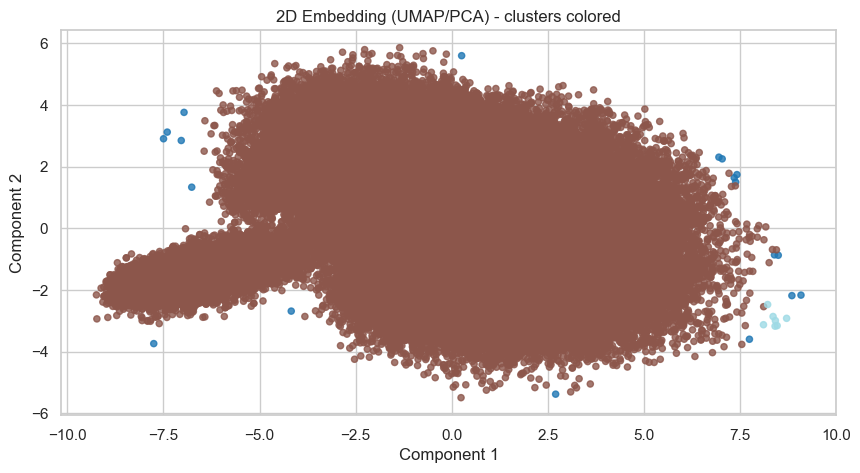

In [10]:
# Cell 6 - embeddings and clustering (operate on X_model but only clean rows to avoid errors)
# Use X_model (full) but must drop any NaNs (should be none after imputation)
X_emb_input = X_model.copy().replace([np.inf, -np.inf], np.nan).dropna()
print("Embedding input shape:", X_emb_input.shape)

# Keep mapping to original indices
emb_index = X_emb_input.index

try:
    if UMAP_AVAILABLE:
        reducer = umap.UMAP(n_components=2, random_state=42)
        emb2d = reducer.fit_transform(X_emb_input)
        print("UMAP succeeded.")
    else:
        raise Exception("UMAP not available")
except Exception as e:
    print("UMAP failed or not available:", str(e))
    pca = PCA(n_components=2, random_state=42)
    emb2d = pca.fit_transform(X_emb_input)
    print("PCA fallback used.")

# Put embeddings back into df for indices that survived
df['_emb_x'] = np.nan
df['_emb_y'] = np.nan
df.loc[emb_index, '_emb_x'] = emb2d[:,0]
df.loc[emb_index, '_emb_y'] = emb2d[:,1]

# Clustering
try:
    if HDBSCAN_AVAILABLE:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
        cluster_labels = clusterer.fit_predict(emb2d)
        print("HDBSCAN succeeded.")
    else:
        raise Exception("HDBSCAN not available")
except Exception as e:
    print("HDBSCAN not available / failed:", str(e))
    dbs = DBSCAN(eps=0.5, min_samples=8)
    cluster_labels = dbs.fit_predict(emb2d)
    print("DBSCAN fallback used.")

# Assign labels back
df['cluster_label'] = np.nan
df.loc[emb_index, 'cluster_label'] = cluster_labels

# Quick scatter (Matplotlib)
plt.figure(figsize=(10,5))
palette = sns.color_palette("tab10", n_colors=min(10, len(np.unique(cluster_labels))+1))
plt.scatter(emb2d[:,0], emb2d[:,1], c=cluster_labels, cmap='tab20', s=20, alpha=0.8)
plt.title("2D Embedding (UMAP/PCA) - clusters colored")
plt.xlabel("Component 1"); plt.ylabel("Component 2")
plt.show()


In [11]:
# Cell 7 - Train XGBoost on log(value_eur)
model = xgb.XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=6, random_state=42, verbosity=0, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Performing CV on log-transformed market value ...")
cv_scores = cross_val_score(model, X_model_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
print("CV R2 (log target):", np.round(cv_scores,4), "mean:", np.round(cv_scores.mean(),4))

# Fit final model on full trainable data
model.fit(X_model_train, y_train)
joblib.dump(model, "scouting_xgb_value_log.pkl")
print("Saved model to scouting_xgb_value_log.pkl")


Performing CV on log-transformed market value ...
CV R2 (log target): [0.4412 0.4393 0.4373 0.4249 0.4291] mean: 0.4344
Saved model to scouting_xgb_value_log.pkl


Building SHAP explainer (Tree Explainer recommended for XGBoost)...


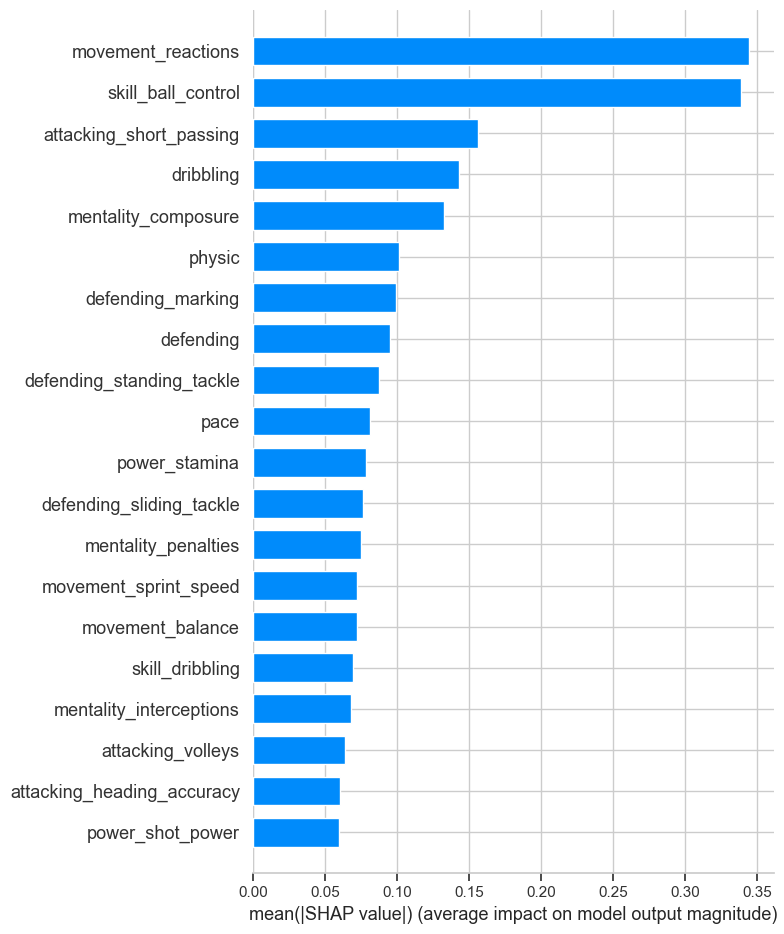

,feature,mean_abs_shap
9,movement_reactions,0.344710
34,skill_ball_control,0.339243
28,attacking_short_passing,0.155906
3,dribbling,0.142887
21,mentality_composure,0.132810
5,physic,0.101183
22,defending_marking,0.099122
4,defending,0.094876
23,defending_standing_tackle,0.087213
0,pace,0.081461


<Figure size 800x400 with 0 Axes>

In [12]:
# Cell 8 - SHAP explainer (may take some seconds)
print("Building SHAP explainer (Tree Explainer recommended for XGBoost)...")
explainer = shap.Explainer(model)
# Use the training matrix for SHAP (X_model_train)
shap_values = explainer(X_model_train)  # returns shap.Explanation

# Global importance bar plot
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values, X_model_train, plot_type='bar', show=True)
plt.tight_layout()

# Save top global features
shap_importance = pd.DataFrame({
    'feature': X_model_train.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)
display(shap_importance.head(20))


In [13]:
# Cell 9 - utilities
from matplotlib import gridspec
from PIL import Image

def radar_plot_player(idx, stat_columns=stat_cols, normalize=True, title=None):
    row = df.loc[idx]
    values = row[stat_columns].astype(float).fillna(0).values.tolist()
    if normalize:
        max_val = np.nanmax(values) if np.nanmax(values) > 0 else 1
        values_norm = [v/max_val for v in values]
    else:
        values_norm = values
    values_norm += [values_norm[0]]
    cats = stat_columns + [stat_columns[0]]
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(r=values_norm, theta=cats, fill='toself', name=row['short_name']))
    fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0,1])), title=title or f"{row['short_name']} — Radar", showlegend=False, height=450)
    return fig

def similar_players_by_stats(idx, top_n=6):
    sims = cosine_similarity([X_sim.loc[idx]], X_sim)[0]
    sim_df = pd.DataFrame({'idx': X_sim.index, 'similarity': sims}).sort_values('similarity', ascending=False)
    sim_df = sim_df[sim_df['idx'] != idx].head(top_n)
    return df.loc[sim_df['idx']].assign(similarity=sim_df['similarity'].values)

def shap_waterfall_save_for_idx(idx, outpath):
    try:
        plt.figure(figsize=(6,4))
        shap.plots.waterfall(shap_values[X_model_train.index.get_loc(idx)], show=False)
        plt.tight_layout()
        plt.savefig(outpath, dpi=150)
        plt.close()
        return outpath
    except Exception as e:
        print("SHAP waterfall save failed:", e)
        return None

def permutation_importance_table():
    res = permutation_importance(model, X_model_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
    imp_df = pd.DataFrame({'feature': X_model_train.columns, 'importance_mean': res.importances_mean}).sort_values('importance_mean', ascending=False)
    return imp_df


In [14]:
# ======================================
# 📄 Player Report Generator – Full Fixed
# ======================================
from reportlab.platypus import SimpleDocTemplate, Image as RLImage, Paragraph, Spacer
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from PIL import Image as PILImage

# Radar chart function
def radar_chart_fast(player_idx, stat_columns=stat_cols, title=None):
    stats = df.loc[player_idx, stat_columns].values
    stats_scaled = stats / stats.max()
    angles = np.linspace(0, 2*np.pi, len(stat_columns), endpoint=False).tolist()
    stats_scaled = np.concatenate((stats_scaled,[stats_scaled[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    ax.plot(angles, stats_scaled, 'o-', linewidth=2, label=df.loc[player_idx,'short_name'])
    ax.fill(angles, stats_scaled, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), stat_columns)
    if title:
        ax.set_title(title, size=14, y=1.1)
    ax.grid(True)
    return fig

# Main report generator
def generate_player_report(player_identifier, by='name', save_pdf=True, out_dir="reports"):
    if by == 'name':
        idxs = df.index[df['short_name'] == player_identifier].tolist()
        if not idxs:
            raise ValueError(f"No player named '{player_identifier}'")
        idx = idxs[0]
    else:
        idx = player_identifier
        if idx not in df.index:
            raise IndexError(f"Index {idx} not in df")
    os.makedirs(out_dir, exist_ok=True)
    player = df.loc[idx]
        # --------- PREDICT MARKET VALUE ----------
    pred_value = None
    try:
        # Ensure model exists and the player is in the model index
        if 'model' in globals() and idx in X_model.index:
            player_features = X_model.loc[idx].values.reshape(1, -1)
            pred_log = model.predict(player_features)[0]
            pred_value = float(np.exp(pred_log))  # Convert back from log value
            print(f"💰 Predicted Market Value: €{pred_value:,.0f}")
        else:
            print("Model or player features not available — skipping prediction")
    except Exception as e:
        print("Prediction failed:", e)
        pred_value = None

    print("="*70)
    print("⚽ PLAYER SCOUTING & TRANSFER MARKET ANALYSIS REPORT")
    print("="*70)
    print(f"Player: {player['short_name']}  | Position: {player['primary_position']}  | Age: {player.get('age','-')}")
    print(f"Club: {player.get('club_name','-')}  | League: {player.get('league_name','-')}")
    print(f"Overall score (engineered): {player.get('overall_score_custom', np.nan):.2f}")
    print("-"*70)

    # Performance snapshot
    metrics = ['overall','potential','pace','shooting','passing','dribbling','defending','physic','movement_reactions']
    print("Performance snapshot:")
    for m in [c for c in metrics if c in df.columns]:
        print(f" - {m}: {player.get(m,'-')}")
    print("-"*70)

    # --------- VISUALS ----------
    # Radar chart
    radar_png = None
    try:
        fig = radar_chart_fast(idx, stat_columns=stat_cols, title=f"{player['short_name']} — Skill Radar")
        radar_png = os.path.join(out_dir, f"{player['short_name']}_radar.png")
        fig.savefig(radar_png, dpi=150, bbox_inches='tight')
        plt.close(fig)
    except Exception as e:
        print("Radar chart generation failed:", e)
        radar_png = None

    # SHAP waterfall
    shap_png = None
    if 'shap_values' in globals() and idx in X_model.index:
        try:
            shap_feat_cols = X_model.columns.tolist()
            local_shap_df = pd.DataFrame({
                'feature': shap_feat_cols,
                'shap_value': shap_values[idx].values
            }).assign(abs_shap=lambda d: d['shap_value'].abs()).sort_values('abs_shap', ascending=False)

            shap_png = os.path.join(out_dir, f"{player['short_name']}_shap_bar.png")
            plt.figure(figsize=(7,5))
            top_local = local_shap_df.head(12).sort_values('shap_value')
            sns.barplot(x='shap_value', y='feature', data=top_local, palette='vlag')
            plt.title(f"Local SHAP contributions — {player['short_name']}")
            plt.tight_layout()
            plt.savefig(shap_png, dpi=150)
            plt.show()
        except Exception as e:
            print("SHAP plot generation failed:", e)
            shap_png = None

    # --------- PDF bundling ---------
    pdf_path = os.path.join(out_dir, f"{player['short_name']}_scouting_report.pdf")
    if save_pdf and REPORTLAB_AVAILABLE:
        doc = SimpleDocTemplate(pdf_path, pagesize=A4)
        styles = getSampleStyleSheet()
        flow = []
        flow.append(Paragraph(f"Player Scouting Report — {player['short_name']}", styles['Title']))
        flow.append(Spacer(1,8))
        flow.append(Paragraph(f"Position: {player['primary_position']} | Age: {player.get('age','-')} | Club: {player.get('club_name','-')} | 💰 Predicted Market Value: €{pred_value:,.0f}", styles['Normal']))
        flow.append(Spacer(1,8))
        flow.append(Paragraph("Performance snapshot:", styles['Heading3']))
        for m in [c for c in metrics if c in df.columns]:
            flow.append(Paragraph(f"{m}: {player.get(m,'-')}", styles['Normal']))
        flow.append(Spacer(1,8))
        for img in [radar_png, shap_png]:
            if img and os.path.exists(img):
                flow.append(RLImage(img, width=450, height=250))
                flow.append(Spacer(1,8))
        doc.build(flow)
        print("PDF saved:", pdf_path)
    elif save_pdf:
        print("ReportLab not installed — PDF not generated.")

    print("Saved visuals to:", out_dir)
    return {
    'index': idx,
    'pred_value_eur': pred_value,
    'radar_png': radar_png,
    'shap_png': shap_png,
    'pdf': pdf_path if os.path.exists(pdf_path) else None
}




Generating report for: Neymar
💰 Predicted Market Value: €39,473,432
⚽ PLAYER SCOUTING & TRANSFER MARKET ANALYSIS REPORT
Player: Neymar  | Position: LW  | Age: 22
Club: FC Barcelona  | League: Spain Primera Division
Overall score (engineered): nan
----------------------------------------------------------------------
Performance snapshot:
 - overall: 86
 - potential: 91
 - pace: 90.0
 - shooting: 80.0
 - passing: 72.0
 - dribbling: 92.0
 - defending: 30.0
 - physic: 58.0
 - movement_reactions: 86
----------------------------------------------------------------------


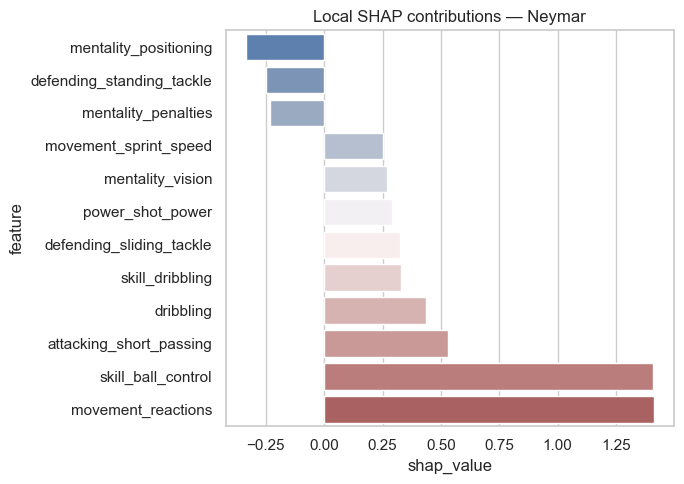

AttributeError: 
paragraph text '<para>Position: LW | Age: 22 | Club: FC Barcelona</para>' caused exception 'str' object has no attribute 'name'

In [43]:
# ======================================
# 📝 Example: Generate Player Scouting Report
# ======================================

# Select top player by market value, fallback to overall_score
if df['value_eur'].notna().sum() > 0:
    top_idx = df['value_eur'].idxmax()
else:
    top_idx = df['overall_score_custom'].idxmax()

top_name = df.loc[top_idx, 'short_name']
print("Generating report for:", top_name)

# Generate report
report_info = generate_player_report(
    player_identifier=top_name,
    by='name',       # using short_name
    save_pdf=True,   # save PDF
    out_dir="reports"
)

# Display returned paths/info
report_info


Generating for L. Messi
💰 Predicted Market Value: €75,868,936
⚽ PLAYER SCOUTING & TRANSFER MARKET ANALYSIS REPORT
Player: L. Messi  | Position: CF  | Age: 27
Club: FC Barcelona  | League: Spain Primera Division
Overall score (engineered): nan
----------------------------------------------------------------------
Performance snapshot:
 - overall: 93
 - potential: 95
 - pace: 93.0
 - shooting: 89.0
 - passing: 86.0
 - dribbling: 96.0
 - defending: 27.0
 - physic: 63.0
 - movement_reactions: 94
----------------------------------------------------------------------


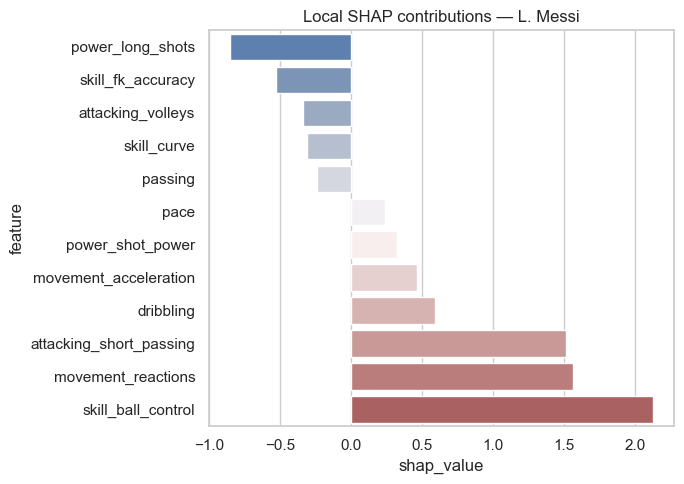

PDF saved: reports_batch\L. Messi_scouting_report.pdf
Saved visuals to: reports_batch
Generating for Neymar Jr
💰 Predicted Market Value: €101,012,960
⚽ PLAYER SCOUTING & TRANSFER MARKET ANALYSIS REPORT
Player: Neymar Jr  | Position: LW  | Age: 27
Club: Paris Saint-Germain  | League: French Ligue 1
Overall score (engineered): nan
----------------------------------------------------------------------
Performance snapshot:
 - overall: 92
 - potential: 92
 - pace: 91.0
 - shooting: 85.0
 - passing: 87.0
 - dribbling: 95.0
 - defending: 32.0
 - physic: 58.0
 - movement_reactions: 92
----------------------------------------------------------------------


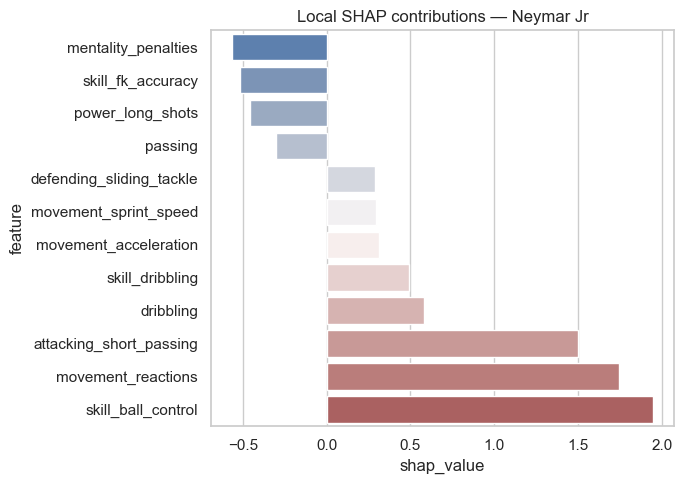

PDF saved: reports_batch\Neymar Jr_scouting_report.pdf
Saved visuals to: reports_batch
Generating for L. Messi
💰 Predicted Market Value: €75,868,936
⚽ PLAYER SCOUTING & TRANSFER MARKET ANALYSIS REPORT
Player: L. Messi  | Position: CF  | Age: 27
Club: FC Barcelona  | League: Spain Primera Division
Overall score (engineered): nan
----------------------------------------------------------------------
Performance snapshot:
 - overall: 93
 - potential: 95
 - pace: 93.0
 - shooting: 89.0
 - passing: 86.0
 - dribbling: 96.0
 - defending: 27.0
 - physic: 63.0
 - movement_reactions: 94
----------------------------------------------------------------------


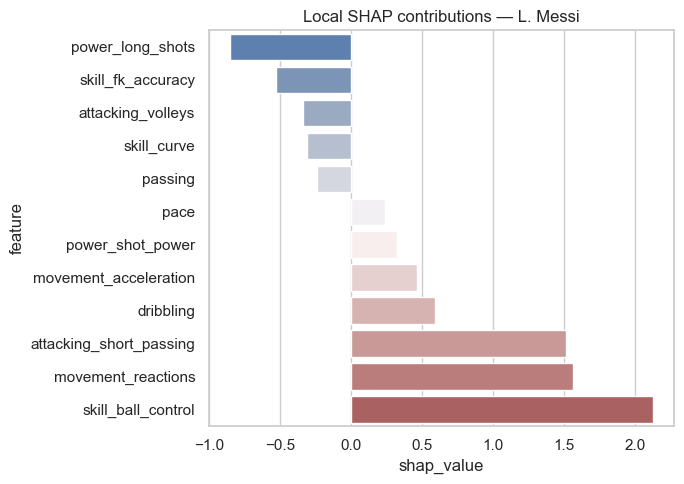

PDF saved: reports_batch\L. Messi_scouting_report.pdf
Saved visuals to: reports_batch
Generating for Neymar Jr
💰 Predicted Market Value: €101,012,960
⚽ PLAYER SCOUTING & TRANSFER MARKET ANALYSIS REPORT
Player: Neymar Jr  | Position: LW  | Age: 27
Club: Paris Saint-Germain  | League: French Ligue 1
Overall score (engineered): nan
----------------------------------------------------------------------
Performance snapshot:
 - overall: 92
 - potential: 92
 - pace: 91.0
 - shooting: 85.0
 - passing: 87.0
 - dribbling: 95.0
 - defending: 32.0
 - physic: 58.0
 - movement_reactions: 92
----------------------------------------------------------------------


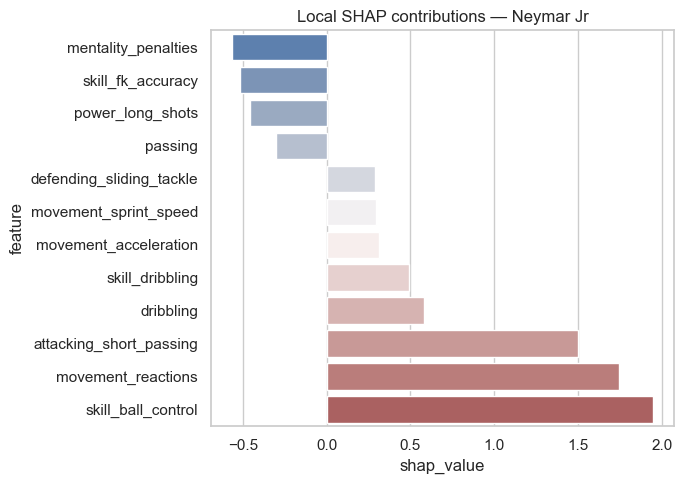

PDF saved: reports_batch\Neymar Jr_scouting_report.pdf
Saved visuals to: reports_batch
Generating for L. Messi
💰 Predicted Market Value: €75,868,936
⚽ PLAYER SCOUTING & TRANSFER MARKET ANALYSIS REPORT
Player: L. Messi  | Position: CF  | Age: 27
Club: FC Barcelona  | League: Spain Primera Division
Overall score (engineered): nan
----------------------------------------------------------------------
Performance snapshot:
 - overall: 93
 - potential: 95
 - pace: 93.0
 - shooting: 89.0
 - passing: 86.0
 - dribbling: 96.0
 - defending: 27.0
 - physic: 63.0
 - movement_reactions: 94
----------------------------------------------------------------------


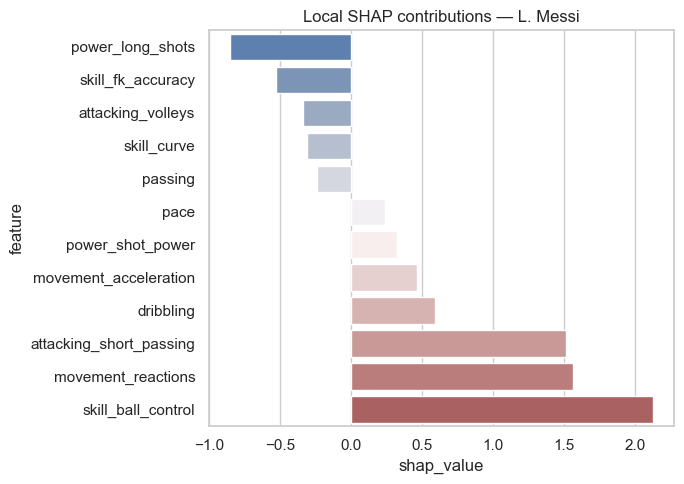

PDF saved: reports_batch\L. Messi_scouting_report.pdf
Saved visuals to: reports_batch


,short_name,pdf,predicted_value_eur
0,L. Messi,reports_batch\L. Messi_scouting_report.pdf,75868936.0
1,Neymar Jr,reports_batch\Neymar Jr_scouting_report.pdf,101012960.0
2,L. Messi,reports_batch\L. Messi_scouting_report.pdf,75868936.0
3,Neymar Jr,reports_batch\Neymar Jr_scouting_report.pdf,101012960.0
4,L. Messi,reports_batch\L. Messi_scouting_report.pdf,75868936.0


Batch reports saved to: reports_batch


In [15]:
# Cell 12 - Batch generate top N (uses predicted value when model available)
N = 5
# compute predicted values for all rows that have model-features
preds = pd.Series(index=X_model.index, dtype=float)
preds.loc[X_model.index] = np.expm1(model.predict(X_model))  # back-transform
df['predicted_value_eur'] = np.nan
df.loc[preds.index, 'predicted_value_eur'] = preds.values

# choose top N by predicted value (fallback to actual if predicted NaN)
candidates = df.copy()
candidates['rank_val'] = candidates['predicted_value_eur'].fillna(candidates['value_eur'].fillna(0))
topN = candidates.sort_values('rank_val', ascending=False).head(N)

out_dir = "reports_batch"
os.makedirs(out_dir, exist_ok=True)
summary = []
for _, r in topN.iterrows():
    print("Generating for", r['short_name'])
    info = generate_player_report(r['short_name'], by='name', save_pdf=True, out_dir=out_dir)
    summary.append({'short_name': r['short_name'], 'pdf': info['pdf'], 'predicted_value_eur': info['pred_value_eur']})

summary_df = pd.DataFrame(summary)
display(summary_df)
summary_df.to_csv(os.path.join(out_dir, "batch_summary.csv"), index=False)
print("Batch reports saved to:", out_dir)


In [16]:
# ===========================================
# 🎛️ Voila Dashboard — Player Report Search
# ===========================================
import ipywidgets as widgets
from IPython.display import display, HTML, Image as IPImage

# 1. Text box for player name
player_input = widgets.Text(
    placeholder='Enter player name (e.g., Neymar)',
    description='Player:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

# 2. Button to trigger
generate_btn = widgets.Button(
    description='Generate Report',
    button_style='success',
    tooltip='Click to generate report',
    icon='check'
)

# 3. Output area to display result
output_area = widgets.Output()

# 4. Function to handle button click
def on_generate_clicked(b):
    with output_area:
        output_area.clear_output()
        player_name = player_input.value.strip()
        if not player_name:
            display(HTML("<b style='color:red;'>⚠️ Please enter a player name.</b>"))
            return

        try:
            result = generate_player_report(player_name, by='name', save_pdf=True)
            
            # Show predicted value
            if result['pred_value_eur'] is not None:
                display(HTML(f"<h3>💰 Predicted Market Value: €{result['pred_value_eur']:,.0f}</h3>"))
            else:
                display(HTML("<b style='color:red;'>Prediction not available for this player.</b>"))

            # Show Radar Chart
            if result['radar_png'] and os.path.exists(result['radar_png']):
                display(HTML("<h4>📊 Skill Radar</h4>"))
                display(IPImage(filename=result['radar_png']))

            # Show SHAP Chart
            if result['shap_png'] and os.path.exists(result['shap_png']):
                display(HTML("<h4>📈 SHAP Feature Contributions</h4>"))
                display(IPImage(filename=result['shap_png']))

        except Exception as e:
            display(HTML(f"<b style='color:red;'>❌ Error: {e}</b>"))

# 5. Bind function to button
generate_btn.on_click(on_generate_clicked)

# 6. Display the dashboard UI
display(player_input, generate_btn, output_area)


Text(value='', description='Player:', layout=Layout(width='400px'), placeholder='Enter player name (e.g., Neym…

Button(button_style='success', description='Generate Report', icon='check', style=ButtonStyle(), tooltip='Clic…

Output()